##### AI TECH - Akademia Innowacyjnych Zastosowań Technologii Cyfrowych. Programu Operacyjnego Polska Cyfrowa na lata 2014-2020
<hr>

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<center>
    <h1 style = "font-size:48px; font-weight:normal"><b>AI</b>-TECH</h1>
    <br>
<br>
<br>
<br>
    <h1 style = "font-size:24px; font-weight:normal">Przykład 2 DO LABORATORIUM 5</h1>
    <h1 style = "font-size:24px">z UCZENIA MASZYNOWEGO</h1>
    <h1 style = "font-size:24px">Sztuczne sieci neuronowe</h1>
    <h1 style = "font-size:24px">Tomasz Neumann</h1>
    <h3 style = "font-size:21px">Klasyfikacja przy użyciu Keras i Tensorflow - Autoenkoder</h3>
</center>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
    </body>
    </html>

![stopka.svg](stopka.svg)

<center>
Projekt współfinansowany ze środków Unii Europejskiej w ramach Europejskiego Funduszu Rozwoju Regionalnego 
Program Operacyjny Polska Cyfrowa na lata 2014-2020,
Oś Priorytetowa nr 3 "Cyfrowe kompetencje społeczeństwa" Działanie  nr 3.2 "Innowacyjne rozwiązania na rzecz aktywizacji cyfrowej" 
Tytuł projektu:  „Akademia Innowacyjnych Zastosowań Technologii Cyfrowych (AI Tech)”
    </center>

<hr>

# 5. Przykład 2

Autokodery to modele sieci neuronowej złożone z dwóch bloków:
- kodera
- dekodera

które przetwarzając dane wejściowe $x$, dążą do ich rekonstrukcji na wyjściu $\hat x$. Związany jest z tym również termin "auto". 

W klasycznym ujęciu autokodery działają na danych wejściowych X bez wyróżniania etykiet y. Rozpatrywany problem polega zatem na nauczeniu modelu takich wag, aby uzyskać idealną rekonstrukcję. Ponieważ nie rozważamy wykorzystania etykiet czy innej formy nadzoru, dlatego klasyczne autokodery zaliczane są do grupy uczenia nienadzorowanego. Należy jednak podkreślić, że znane są również prace w zakresie autokoderów z nadzorem (ang. Supervised AutoEncoders SAE), których celem jest rekonstrukcja zarówno danych wejściowych jak i etykiet.

Rolą kodera jest transformacja $L$ wymiarowych danych wejściowych ($L$ - liczba cech, danych surowych, itp.) do $E$ wymiarowych, nowych cech ($E<L$). Transformacja reprezentacji danych musi być tak dokonana, aby dekoder mógł zrekonstruować dane w zmienionej reprezentacji na dane jak najbardziej podobne do reprezentacji źródłowej. Kryterium podobieństwa wyznaczać będzie funkcja kosztu, np.:

$$L=||\textbf x- \hat {\textbf x}||^2$$

Stosując model MLP, blok kodera można zapisać jako:

$$ \textbf z = a(\textbf W^{(k)} \textbf x^{(k)})$$
natomiast blok dekodera jako:

$$ \hat {\textbf x} = a(\textbf W^{(d)} \textbf z^{(d)})$$

gdzie: $a()$ - to funkcja aktywacji, $W$ - parametry modelu (z lub bez obciążenia $W_0$), $x$ - dane wejsciowe (z lub bez $x_0=1$).


Do celów tego przykładu użyjemy zbiór danych MNIST Fashion. Na wzór znanego zbioru zeskanowanych cyfr MNIST utworzono zbiór danych MNIST Fashion zawierający 70 000 obrazów (60000 z. treningowy + 10000 z. testowy) o rozdzielczości 28x28 pikseli, każdy przedstawiający zdjęcie odzieży należące do jednej z 10 klas:

0 T-shirt/top, 1 Trouser, 2 Pullover, 3 Dress, 4 Coat, 5 Sandal, 6 Shirt, 7 Sneaker, 8 Bag, 9 Ankle boot

Oryginalny zbiór dostępny jest na stronie: https://github.com/zalandoresearch/fashion-mnist (The MIT License (MIT) Copyright © [2017] Zalando)

Zastosowanie zbioru zrealizowane zostanie poprzez dostępne API w TensorFlow.

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib

print(tf.__version__)

(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

print (X_train.shape)
print (X_test.shape)

2.8.0
(60000, 28, 28)
(10000, 28, 28)


Bag


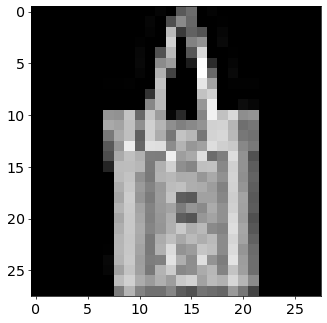

In [2]:
labels = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandalv", 
          "Shirt", "Sneaker", "Bag", "Ankle boot"]
example = 57
print(labels[y_train[example]])

matplotlib.rcParams.update({'font.size': 16})
fig = plt.figure(figsize=(9, 6), dpi=64)
plt.imshow(X_train[example], cmap='gray')
plt.show()

Zrealizujemy teraz model autokodera, który będzie zmieniał reprezentację danych do nowej $E$ wymiarowej przestrzeni ukrytej. Wprowadzona zostanie zmienna latent_space_dim do określenia wymiaru $E$ (będzie można eksperymentować z wpływem doboru rozmiaru reprezentacji danych w przestrzeni ukrytej na wyniki autokodera). 

Jeśli $E < L$ (liczba cech zbioru oryginalnego) mówimy o niekompletnych autokoderach (ang. undercomplete autoencoders).

Jeśli $E > L$ mówimy o nadkompletnych autokoderach (ang. overcomplete autoencoders), często związanych z danymi reprezentowanymi w warstwie ukrytej w sposób rzadki (dużo zer - wiele neuronów nieaktywnych) - ang. sparse autoencoders.

Przeanazlizujmy aktualnie przypadek, gdzi $E<L$. 

In [3]:
from tensorflow.keras import layers, losses

class AE(tf.keras.models.Model):
  def __init__(self, data_shape, lat_dim, enc_act, dec_act):
    super(AE, self).__init__()
    self.latent_space_dim = lat_dim   

    self.encoder = tf.keras.Sequential([
      # Kształt danych (60000, 28, 28), więc dokonywane jest ich spłaszczenie                                 
      layers.Flatten(),
      layers.Dense(latent_space_dim, activation=enc_act)
    ])

    self.decoder = tf.keras.Sequential([
      # Kształt danych (60000, 28, 28), a na wyjściu oczekujemy 28*28
      layers.Dense(data_shape[1]*data_shape[2], activation=dec_act),
      layers.Reshape((data_shape[1],data_shape[2]))
    ])

  # forward projection
  def call(self, x):
    z = self.encoder(x)
    x_e = self.decoder(z)
    return x_e

In [4]:
latent_space_dim = 16 
encoder_activation = 'relu'
decoder_activation = 'sigmoid'
epochs = 10
print(X_train.shape)

ae = AE(X_train.shape, latent_space_dim, encoder_activation, decoder_activation)
ae.compile(optimizer='adam', loss=losses.MeanSquaredError(), metrics=['accuracy'])
history = ae.fit(X_train, X_train, epochs=epochs, shuffle=True, 
       validation_data=(X_test, X_test))

(60000, 28, 28)
Epoch 1/10
1875/1875 [==============================] - 2s 928us/step - loss: 0.0335 - accuracy: 0.0880 - val_loss: 0.0213 - val_accuracy: 0.1029
Epoch 2/10
1875/1875 [==============================] - 2s 876us/step - loss: 0.0194 - accuracy: 0.1063 - val_loss: 0.0185 - val_accuracy: 0.1079
Epoch 3/10
1875/1875 [==============================] - 2s 883us/step - loss: 0.0182 - accuracy: 0.1085 - val_loss: 0.0181 - val_accuracy: 0.1089
Epoch 4/10
1875/1875 [==============================] - 2s 884us/step - loss: 0.0179 - accuracy: 0.1104 - val_loss: 0.0178 - val_accuracy: 0.1134
Epoch 5/10
1875/1875 [==============================] - 2s 880us/step - loss: 0.0177 - accuracy: 0.1116 - val_loss: 0.0177 - val_accuracy: 0.1134
Epoch 6/10
1875/1875 [==============================] - 2s 926us/step - loss: 0.0176 - accuracy: 0.1128 - val_loss: 0.0177 - val_accuracy: 0.1096
Epoch 7/10
1875/1875 [==============================] - 2s 873us/step - loss: 0.0176 - accuracy: 0.1140 - va

W celu ilustracji działania zastosujmy koder i dekoder dla zbioru testowego.

In [5]:
img_encoded = ae.encoder(X_test).numpy()
img_decoded = ae.decoder(img_encoded).numpy()

Zilustrujmy następnie obraz oryginalny oraz zrekonstruowany przez autokoder.

Wejściowy rozmiar obrazu (shape): (28, 28)
Rozmiar warstwy ukrytej (shape): (16,)
Etykieta dla przykładu: Shirt


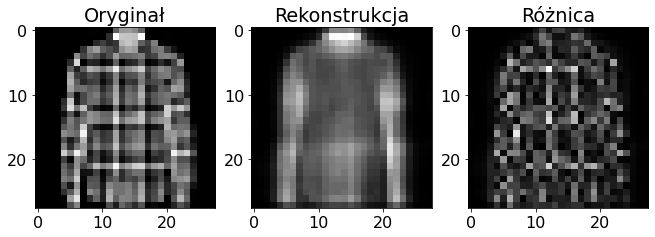

In [8]:
example = 7

print("Wejściowy rozmiar obrazu (shape):", X_test[example].shape)
print("Rozmiar warstwy ukrytej (shape):", img_encoded[example].shape)

print("Etykieta dla przykładu:", labels[y_test[example]])

matplotlib.rcParams.update({'font.size': 16})
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(11,11))

ax1.set_title("Oryginał")
ax1.imshow(X_test[example], cmap='gray')

ax2.set_title("Rekonstrukcja")
ax2.imshow(img_decoded[example], cmap='gray')

ax3.set_title("Różnica")
ax3.imshow(np.abs(img_decoded[example]-X_test[example]), cmap='gray')
plt.show()

Można zaobserwować efekt wygładzenia obrazu (wygładzenie to filtracja dolnoprzepustowa - zmniejszamy częstotliwości przestrzenne, czyli liczbę zmian wartości pikseli na jednostkę długości).

Oczywiste staje się wówczas pytanie, czy moglibyśmy zastosować wyuczony autokoder do odszumiania obrazów.

Wygenerujemy obraz z szumem i zastosujmy ten sam model, który trenowaliśmy wyżej.


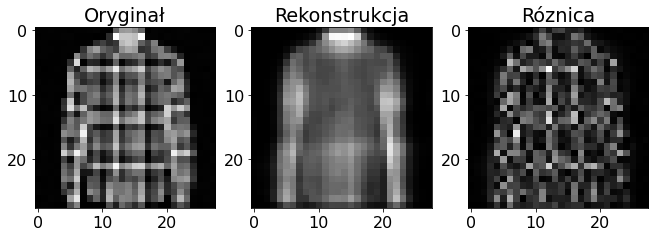

In [9]:
noise_amp = 0.003
noise = noise_amp * np.random.normal(size=(28,28))
img_example = np.array(X_test[example] + noise).reshape((1,28,28))


img_example_encoded = ae.encoder(img_example).numpy()
img_example_decoded = ae.decoder(img_example_encoded).numpy()

matplotlib.rcParams.update({'font.size': 16})
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(11,11))

ax1.set_title("Oryginał")
ax1.imshow(img_example[0], cmap='gray')

ax2.set_title("Rekonstrukcja")
ax2.imshow(img_example_decoded[0], cmap='gray')

ax3.set_title("Róznica")
ax3.imshow(np.abs(img_example_decoded[0]-img_example[0]), cmap='gray')
plt.show()

Wyraźnie widać, że tak prosty, stosunkowo płytki model z powodzeniem poradził sobie z problemem odszumiania obrazu. 

Autokodery mogą być zastosowane nie tylko do obrazów ale również do sekwencji danych, sygnałów, danych 3D, itd.

# Zadania do wykonania

<p><b>Zadanie 1</b></p> Przeprojektuj model dla danych wejściowych zbioru cyfr MNIST oraz wykonaj test odszumiania obrazu dla cyfry będącej ostatnią cyfrą w Twoim numerze albumu.



![stopka.svg](stopka.svg)